In [20]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import random
import matplotlib.pyplot as plt

In [21]:
idx = pd.date_range(start="2020-01-01", end ="2022-01-01", freq ="M")
idx

DatetimeIndex(['2020-01-31', '2020-02-29', '2020-03-31', '2020-04-30',
               '2020-05-31', '2020-06-30', '2020-07-31', '2020-08-31',
               '2020-09-30', '2020-10-31', '2020-11-30', '2020-12-31',
               '2021-01-31', '2021-02-28', '2021-03-31', '2021-04-30',
               '2021-05-31', '2021-06-30', '2021-07-31', '2021-08-31',
               '2021-09-30', '2021-10-31', '2021-11-30', '2021-12-31'],
              dtype='datetime64[ns]', freq='M')

In [22]:
test_df = pd.DataFrame({"values": [random.randint(0,100) for x in range(0,24)]}, index = idx)
test_df.head()

,values
2020-01-31,28
2020-02-29,86
2020-03-31,67
2020-04-30,8
2020-05-31,17


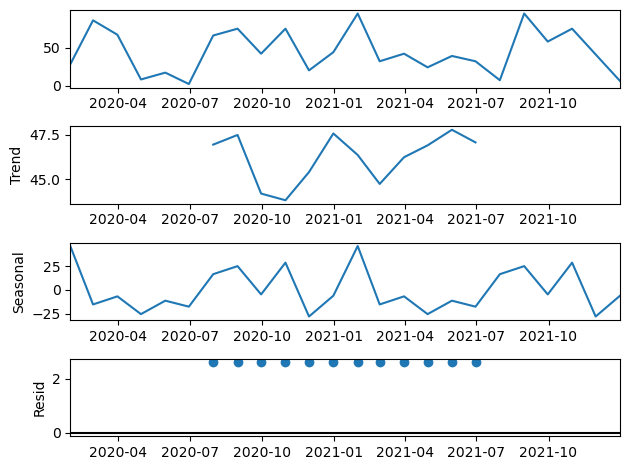

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose
seasonal_decompose(test_df).plot()
plt.show()

In [18]:
"""
Seasonal Decomposition by Moving Averages
"""
import numpy as np
import pandas as pd
from pandas.core.nanops import nanmean as pd_nanmean

from statsmodels.tools.validation import PandasWrapper, array_like
# from statsmodels.tsa.stl._stl import STL
from statsmodels.tsa.filters.filtertools import convolution_filter
# from statsmodels.tsa.stl.mstl import MSTL
from statsmodels.tsa.tsatools import freq_to_period

__all__ = [
    "STL",
    "seasonal_decompose",
    "seasonal_mean",
    "DecomposeResult",
    "MSTL",
]


def _extrapolate_trend(trend, npoints):
    """
    Replace nan values on trend's end-points with least-squares extrapolated
    values with regression considering npoints closest defined points.
    """
    front = next(
        i for i, vals in enumerate(trend) if not np.any(np.isnan(vals))
    )
    back = (
        trend.shape[0]
        - 1
        - next(
            i
            for i, vals in enumerate(trend[::-1])
            if not np.any(np.isnan(vals))
        )
    )
    front_last = min(front + npoints, back)
    back_first = max(front, back - npoints)

    k, n = np.linalg.lstsq(
        np.c_[np.arange(front, front_last), np.ones(front_last - front)],
        trend[front:front_last],
        rcond=-1,
    )[0]
    extra = (np.arange(0, front) * np.c_[k] + np.c_[n]).T
    if trend.ndim == 1:
        extra = extra.squeeze()
    trend[:front] = extra

    k, n = np.linalg.lstsq(
        np.c_[np.arange(back_first, back), np.ones(back - back_first)],
        trend[back_first:back],
        rcond=-1,
    )[0]
    extra = (np.arange(back + 1, trend.shape[0]) * np.c_[k] + np.c_[n]).T
    if trend.ndim == 1:
        extra = extra.squeeze()
    trend[back + 1 :] = extra

    return trend


def seasonal_mean(x, period):
    """
    Return means for each period in x. period is an int that gives the
    number of periods per cycle. E.g., 12 for monthly. NaNs are ignored
    in the mean.
    """
    return np.array([pd_nanmean(x[i::period], axis=0) for i in range(period)])


def seasonal_decompose(
    x,
    model="additive",
    filt=None,
    period=None,
    two_sided=True,
    extrapolate_trend=0,
):
    """
    Seasonal decomposition using moving averages.

    Parameters
    ----------
    x : array_like
        Time series. If 2d, individual series are in columns. x must contain 2
        complete cycles.
    model : {"additive", "multiplicative"}, optional
        Type of seasonal component. Abbreviations are accepted.
    filt : array_like, optional
        The filter coefficients for filtering out the seasonal component.
        The concrete moving average method used in filtering is determined by
        two_sided.
    period : int, optional
        Period of the series. Must be used if x is not a pandas object or if
        the index of x does not have  a frequency. Overrides default
        periodicity of x if x is a pandas object with a timeseries index.
    two_sided : bool, optional
        The moving average method used in filtering.
        If True (default), a centered moving average is computed using the
        filt. If False, the filter coefficients are for past values only.
    extrapolate_trend : int or 'freq', optional
        If set to > 0, the trend resulting from the convolution is
        linear least-squares extrapolated on both ends (or the single one
        if two_sided is False) considering this many (+1) closest points.
        If set to 'freq', use `freq` closest points. Setting this parameter
        results in no NaN values in trend or resid components.

    Returns
    -------
    DecomposeResult
        A object with seasonal, trend, and resid attributes.

    See Also
    --------
    statsmodels.tsa.filters.bk_filter.bkfilter
        Baxter-King filter.
    statsmodels.tsa.filters.cf_filter.cffilter
        Christiano-Fitzgerald asymmetric, random walk filter.
    statsmodels.tsa.filters.hp_filter.hpfilter
        Hodrick-Prescott filter.
    statsmodels.tsa.filters.convolution_filter
        Linear filtering via convolution.
    statsmodels.tsa.seasonal.STL
        Season-Trend decomposition using LOESS.

    Notes
    -----
    This is a naive decomposition. More sophisticated methods should
    be preferred.

    The additive model is Y[t] = T[t] + S[t] + e[t]

    The multiplicative model is Y[t] = T[t] * S[t] * e[t]

    The results are obtained by first estimating the trend by applying
    a convolution filter to the data. The trend is then removed from the
    series and the average of this de-trended series for each period is
    the returned seasonal component.
    """
    pfreq = period
    pw = PandasWrapper(x)
    if period is None:
        pfreq = getattr(getattr(x, "index", None), "inferred_freq", None)

    x = array_like(x, "x", maxdim=2)
    nobs = len(x)

    if not np.all(np.isfinite(x)):
        raise ValueError("This function does not handle missing values")
    if model.startswith("m"):
        if np.any(x <= 0):
            raise ValueError(
                "Multiplicative seasonality is not appropriate "
                "for zero and negative values"
            )

    if period is None:
        if pfreq is not None:
            pfreq = freq_to_period(pfreq)
            period = pfreq
        else:
            raise ValueError(
                "You must specify a period or x must be a pandas object with "
                "a PeriodIndex or a DatetimeIndex with a freq not set to None"
            )
    if x.shape[0] < 2 * pfreq:
        raise ValueError(
            f"x must have 2 complete cycles requires {2 * pfreq} "
            f"observations. x only has {x.shape[0]} observation(s)"
        )

    if filt is None:
        if period % 2 == 0:  # split weights at ends
            filt = np.array([0.5] + [1] * (period - 1) + [0.5]) / period
        else:
            filt = np.repeat(1.0 / period, period)

    nsides = int(two_sided) + 1
    trend = convolution_filter(x, filt, nsides)

    if extrapolate_trend == "freq":
        extrapolate_trend = period - 1

    if extrapolate_trend > 0:
        trend = _extrapolate_trend(trend, extrapolate_trend + 1)

    if model.startswith("m"):
        detrended = x / trend
    else:
        detrended = x - trend

    period_averages = seasonal_mean(detrended, period)

    if model.startswith("m"):
        period_averages /= np.mean(period_averages, axis=0)
    else:
        period_averages -= np.mean(period_averages, axis=0)

    seasonal = np.tile(period_averages.T, nobs // period + 1).T[:nobs]

    if model.startswith("m"):
        resid = x / seasonal / trend
    else:
        resid = detrended - seasonal

    results = []
    for s, name in zip(
        (seasonal, trend, resid, x), ("seasonal", "trend", "resid", None)
    ):
        results.append(pw.wrap(s.squeeze(), columns=name))
    return DecomposeResult(
        seasonal=results[0],
        trend=results[1],
        resid=results[2],
        observed=results[3],
    )


class DecomposeResult:
    """
    Results class for seasonal decompositions

    Parameters
    ----------
    observed : array_like
        The data series that has been decomposed.
    seasonal : array_like
        The seasonal component of the data series.
    trend : array_like
        The trend component of the data series.
    resid : array_like
        The residual component of the data series.
    weights : array_like, optional
        The weights used to reduce outlier influence.
    """

    def __init__(self, observed, seasonal, trend, resid, weights=None):
        self._seasonal = seasonal
        self._trend = trend
        if weights is None:
            weights = np.ones_like(observed)
            if isinstance(observed, pd.Series):
                weights = pd.Series(
                    weights, index=observed.index, name="weights"
                )
        self._weights = weights
        self._resid = resid
        self._observed = observed

    @property
    def observed(self):
        """Observed data"""
        return self._observed

    @property
    def seasonal(self):
        """The estimated seasonal component"""
        return self._seasonal

    @property
    def trend(self):
        """The estimated trend component"""
        return self._trend

    @property
    def resid(self):
        """The estimated residuals"""
        return self._resid

    @property
    def weights(self):
        """The weights used in the robust estimation"""
        return self._weights

    @property
    def nobs(self):
        """Number of observations"""
        return self._observed.shape

    def plot(
        self,
        observed=True,
        seasonal=True,
        trend=True,
        resid=True,
        weights=False,
    ):
        """
        Plot estimated components

        Parameters
        ----------
        observed : bool
            Include the observed series in the plot
        seasonal : bool
            Include the seasonal component in the plot
        trend : bool
            Include the trend component in the plot
        resid : bool
            Include the residual in the plot
        weights : bool
            Include the weights in the plot (if any)

        Returns
        -------
        matplotlib.figure.Figure
            The figure instance that containing the plot.
        """
        from pandas.plotting import register_matplotlib_converters

        from statsmodels.graphics.utils import _import_mpl

        plt = _import_mpl()
        register_matplotlib_converters()
        series = [(self._observed, "Observed")] if observed else []
        series += [(self.trend, "trend")] if trend else []

        if self.seasonal.ndim == 1:
            series += [(self.seasonal, "seasonal")] if seasonal else []
        elif self.seasonal.ndim > 1:
            if isinstance(self.seasonal, pd.DataFrame):
                for col in self.seasonal.columns:
                    series += (
                        [(self.seasonal[col], "seasonal")] if seasonal else []
                    )
            else:
                for i in range(self.seasonal.shape[1]):
                    series += (
                        [(self.seasonal[:, i], "seasonal")] if seasonal else []
                    )

        series += [(self.resid, "residual")] if resid else []
        series += [(self.weights, "weights")] if weights else []

        if isinstance(self._observed, (pd.DataFrame, pd.Series)):
            nobs = self._observed.shape[0]
            xlim = self._observed.index[0], self._observed.index[nobs - 1]
        else:
            xlim = (0, self._observed.shape[0] - 1)

        fig, axs = plt.subplots(len(series), 1)
        for i, (ax, (series, def_name)) in enumerate(zip(axs, series)):
            if def_name != "residual":
                ax.plot(series)
            else:
                ax.plot(series, marker="o", linestyle="none")
                ax.plot(xlim, (0, 0), color="#000000", zorder=-3)
            name = getattr(series, "name", def_name)
            if def_name != "Observed":
                name = name.capitalize()
            title = ax.set_title if i == 0 and observed else ax.set_ylabel
            title(name)
            ax.set_xlim(xlim)

        # fig.tight_layout()
        return fig.tight_layout


In [ ]:
prodcustreg_pivot.isnull().sum()

PIDWACE2P3PM_bought_by_SAMSUNG_in_Korea    1
TRCT31C0BKP_bought_by_TSMC_in_Taiwan       1
TRCT32C0BKP_bought_by_TSMC_in_Taiwan       2
dtype: int64